In [1]:
import numpy as np
import matplotlib.pyplot as plt
import twa
from twa.data import SystemFamily, FlowSystemODE, topo_point_vs_cycle
from twa.utils import plot_diverge_scale
import torch
import random

random.seed(2)
torch.manual_seed(2)

torch.use_deterministic_algorithms(True) 
%set_env CUBLAS_WORKSPACE_CONFIG=:4096:8


device = 'cuda'

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


simple_oscillator
suphopf
lienard_poly
lienard_sigmoid
vanderpol
bzreaction
selkov


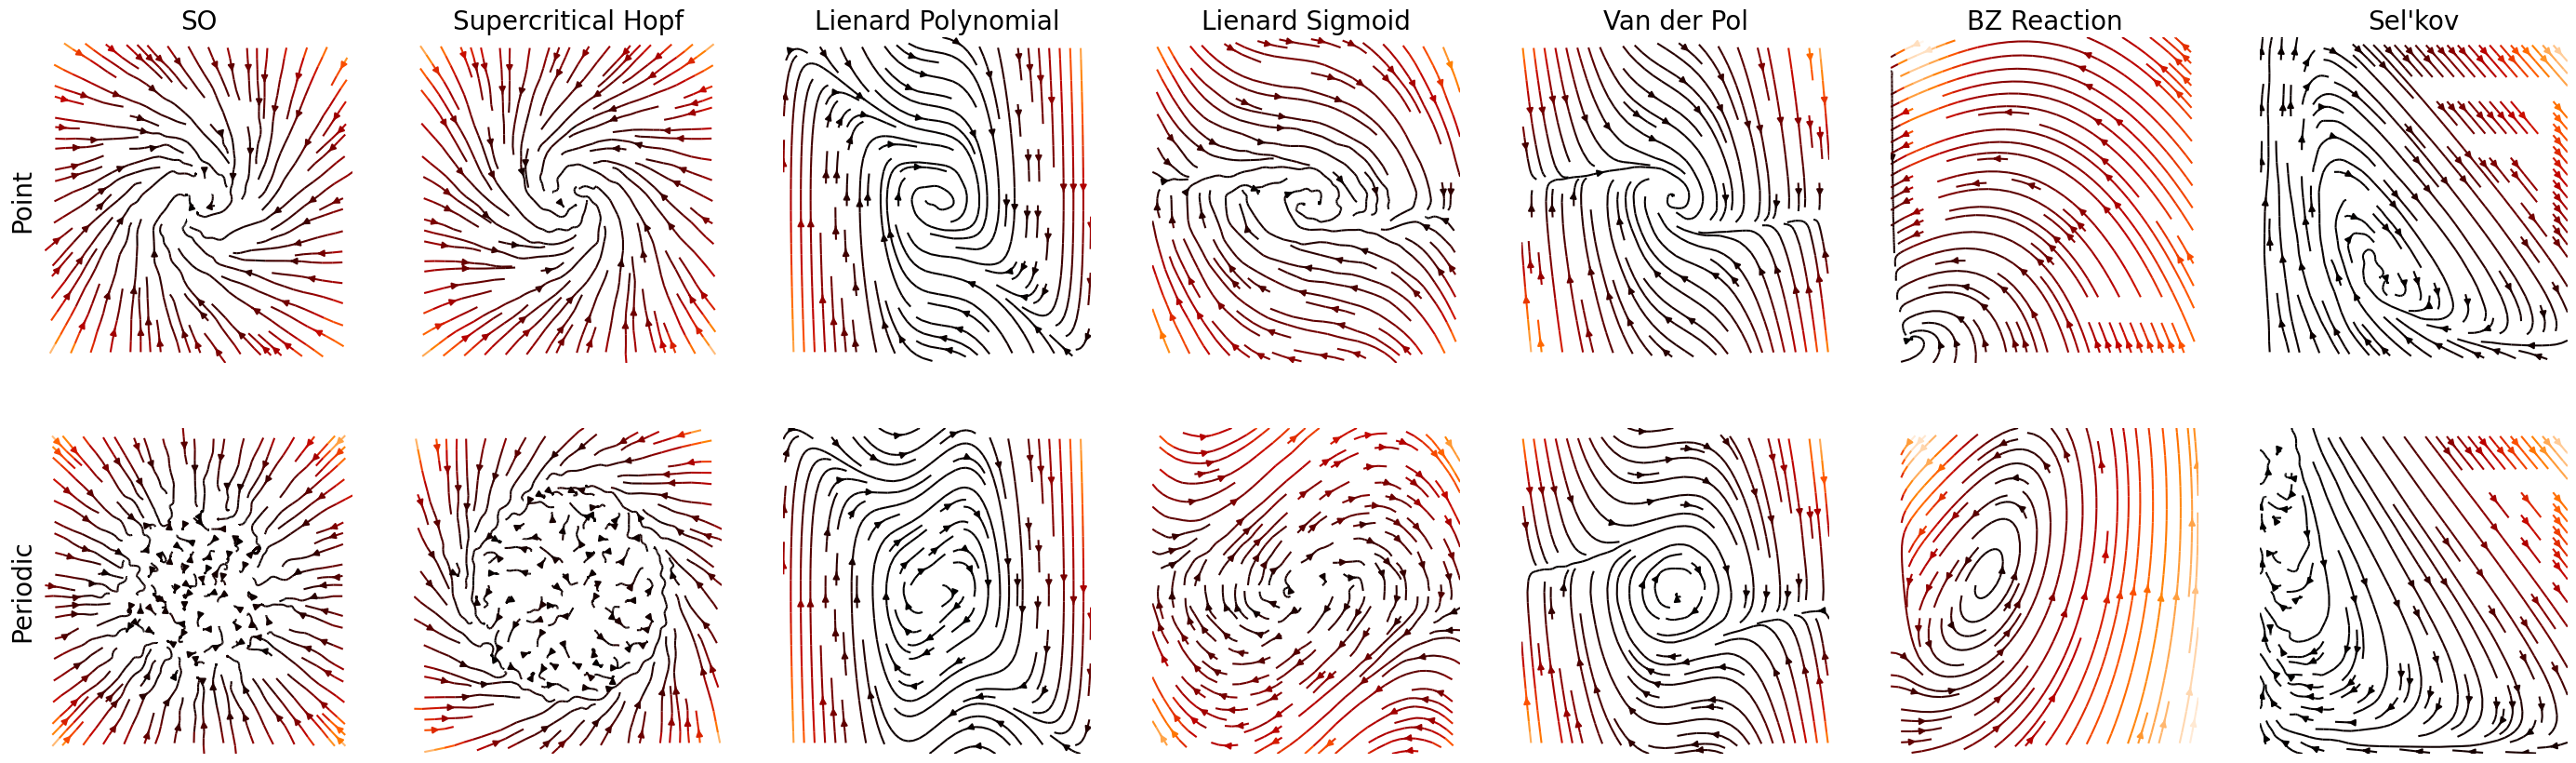

In [2]:
# plot classical systems

sys_descs = {}
sys_descs['simple_oscillator'] = 'SO'
sys_descs['suphopf'] = 'Supercritical Hopf'
sys_descs['lienard_poly'] = 'Lienard Polynomial'
sys_descs['lienard_sigmoid'] = 'Lienard Sigmoid'
sys_descs['vanderpol'] = 'Van der Pol'
sys_descs['bzreaction'] = 'BZ Reaction'
sys_descs['selkov'] = 'Sel\'kov'

syss = list(sys_descs.keys())
nsyss = len(syss)

nrows = 2
ncols = nsyss
fig, axs = plt.subplots(nrows, ncols, figsize=(5 * ncols, nrows * 5))
axs = axs.reshape(nrows, ncols)
num_samples = 10 # sample 10 but plot one for point and one for cycle
sampler_type = 'random'
noise = 0.1

for isys, sys in enumerate(syss):
    print(sys)
    sf = SystemFamily(data_name=sys, device=device)
    res = sf.generate_flows(num_samples=num_samples, sampler_type=sampler_type)
    
    params = res['params'] 
    vectors = res['vectors']
    DEs = res['DEs']
    poly_params = res['poly_params']
    fixed_pts = res['fixed_pts']
    topos = res['topos']

    coords = DEs[0].coords_xy
    vectors += np.random.randn(*vectors.shape) * noise
            
    labels = topo_point_vs_cycle(topos)
    for icol, col in enumerate(labels.columns):
        idx = np.where(labels[col] == 1)[0]
        if len(idx) > 0:
            idx = idx[0]
            twa.dt.FlowSystemODE.plot_trajectory_2d_(coords, vectors[idx], ax=axs[icol, isys])

        axs[icol, isys].set_yticks([])
        axs[icol, isys].set_xticks([])
        axs[icol,isys].set_xlabel('')
        axs[icol,isys].set_ylabel('')
        axs[icol,isys].spines['top'].set_visible(False)
        axs[icol,isys].spines['right'].set_visible(False)
        axs[icol,isys].spines['bottom'].set_visible(False)
        axs[icol,isys].spines['left'].set_visible(False)

        axs[icol,0].set_ylabel(col, fontsize=20)
    
    axs[0,isys].set_title(sys_descs[sys], fontsize=20)


Text(0, 0.5, 'Augmented SO')

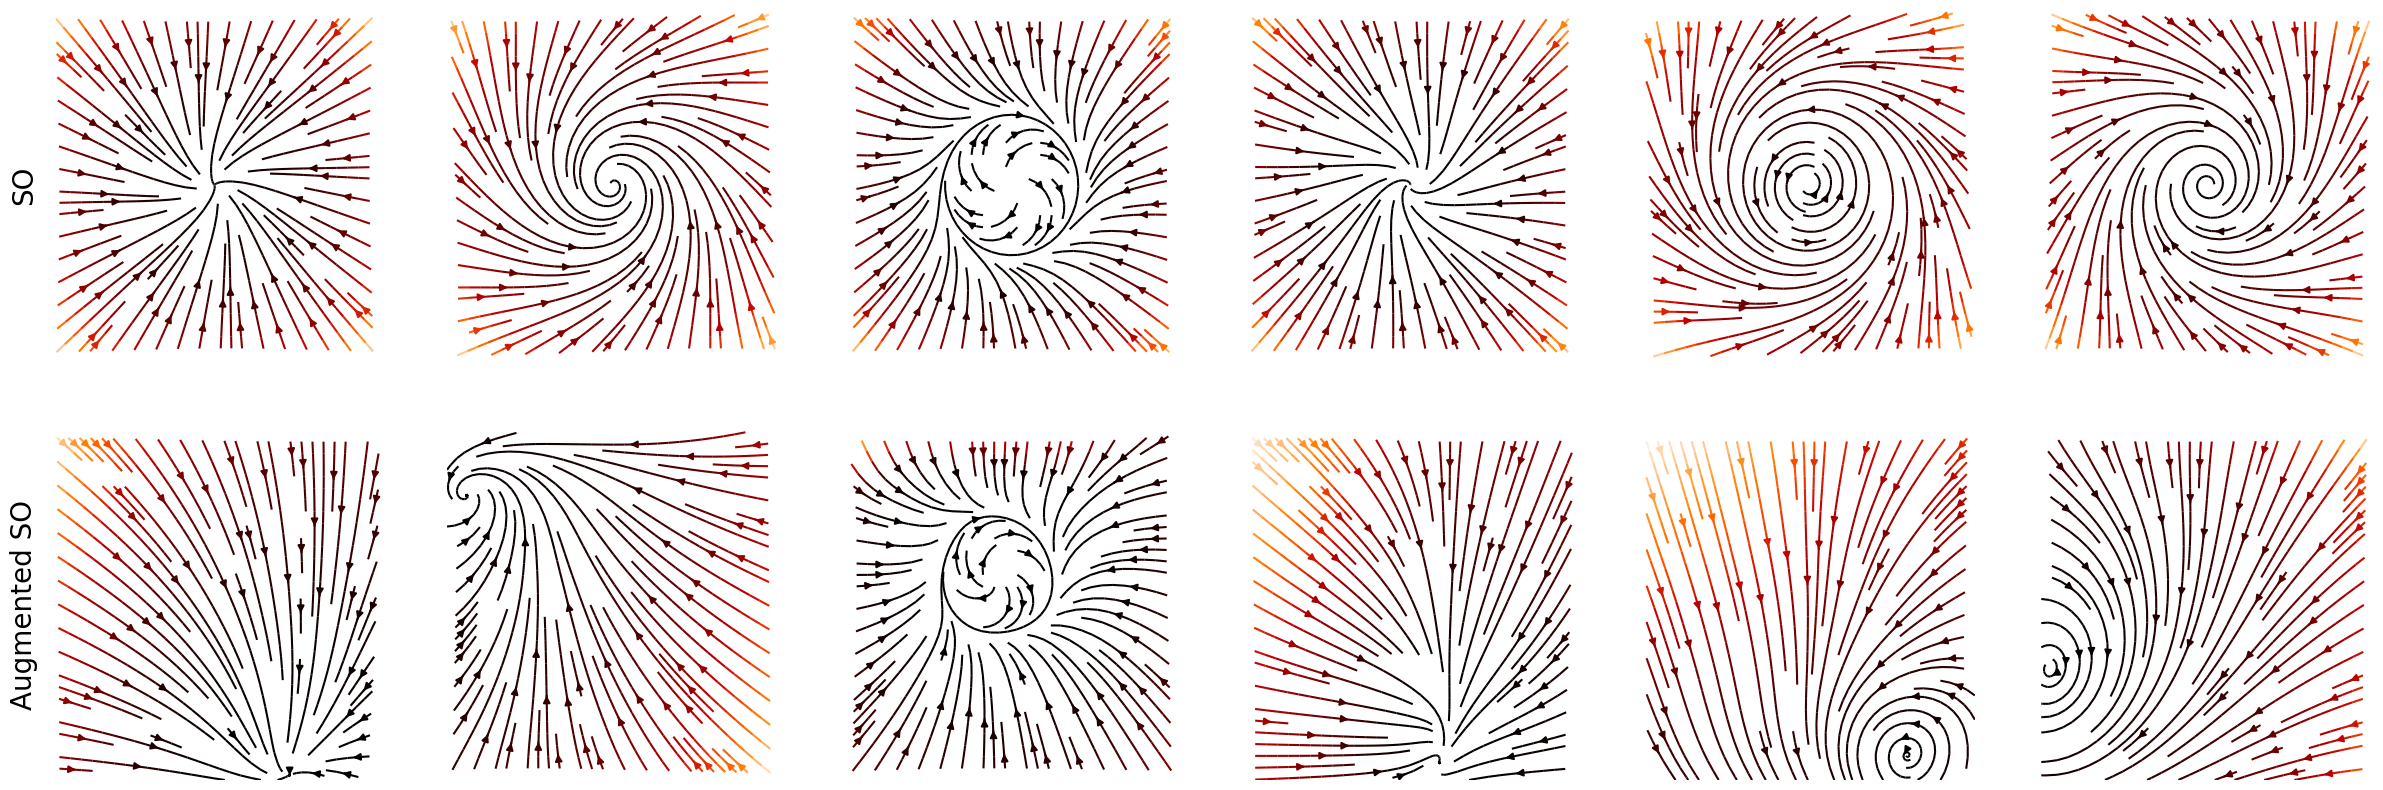

In [3]:
# plot SO augmentations
sys = 'simple_oscillator'
augment_type = 'NSF_CL'

num_samples = 6
sf = SystemFamily(data_name=sys)

res = sf.generate_flows(num_samples=num_samples, augment_type=augment_type)
nrows = 2
fig, axs = plt.subplots(nrows, num_samples, figsize=(5*num_samples, 5*nrows))
coords = res['DEs'][0].coords_xy
vectors = res['vectors']
vectors_pert = res['vectors_pert']


for i in range(num_samples):
    FlowSystemODE.plot_trajectory_2d_(coords=coords, vectors=vectors[i], ax=axs[0,i])
    FlowSystemODE.plot_trajectory_2d_(coords=coords, vectors=vectors_pert[i], ax=axs[1,i])
    for j in [0,1]:
        axs[j,i].set_yticks([])
        axs[j,i].set_xticks([])
        axs[j,i].set_xlabel('')
        axs[j,i].set_ylabel('')
        axs[j,i].spines['top'].set_visible(False)
        axs[j,i].spines['right'].set_visible(False)
        axs[j,i].spines['bottom'].set_visible(False)
        axs[j,i].spines['left'].set_visible(False)
        
axs[0,0].set_ylabel('SO', fontsize=20)
axs[1,0].set_ylabel('Augmented SO', fontsize=20)


0.10000000149011612 2.0000000536441807
0.10000000149011612 1.1111111460644527
1.0 0.9615384623650792
1.0 0.9259259274589672


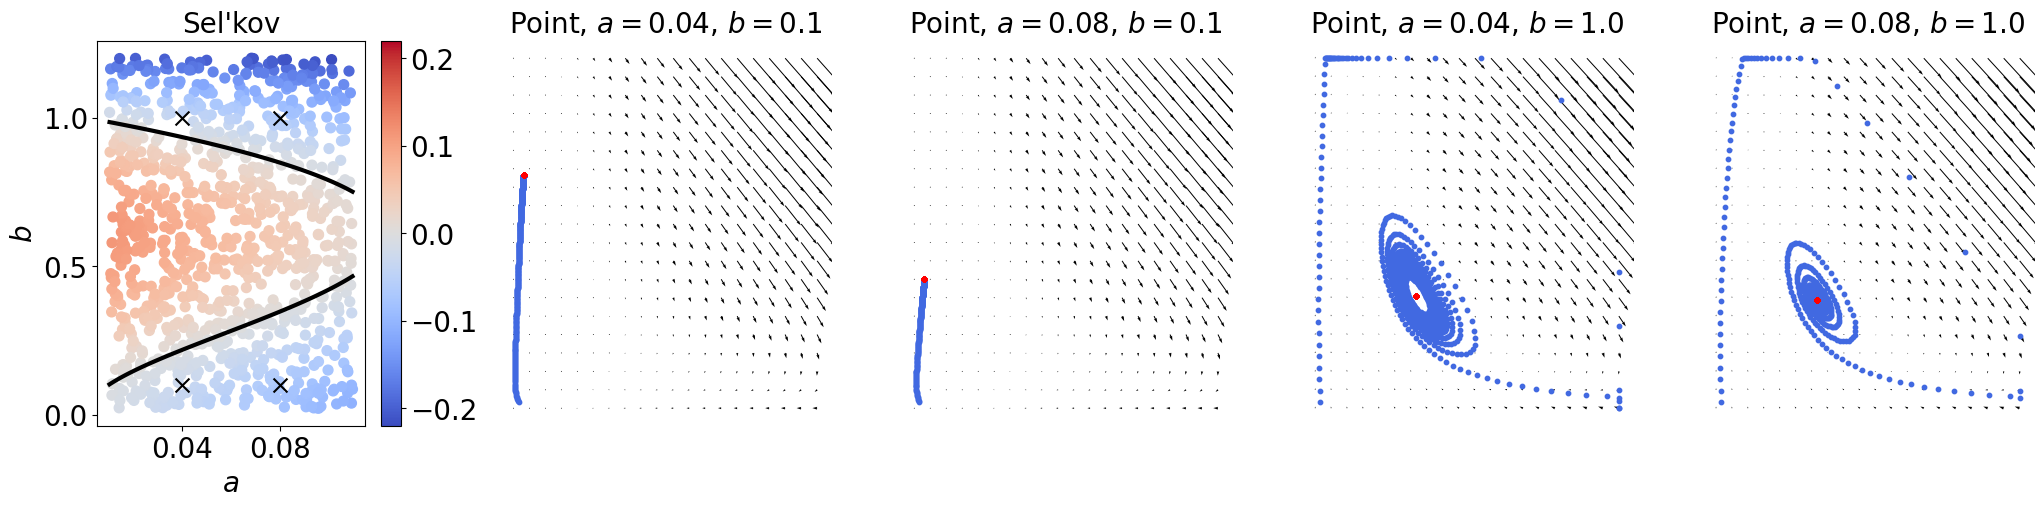

In [5]:
# plot instances from BZ or selkov

sys = 'selkov'; paramss = [[0.04, 0.1], [0.08, 0.1], [0.04, 1.0], [0.08, 1.0], ]
# sys = 'bzreaction'; paramss = [[10,2], [16,2], [10,5], [16,5]]; 

num_samples = 1000
sf = SystemFamily(data_name=sys)
DE = sf.DE
res = sf.generate_flows(num_samples=num_samples)
    
sysp = res['params']
dists = res['dists'].reshape(-1)
topos = res['topos']
labels = topo_point_vs_cycle(topos)
has_cyc = labels['Periodic'].values
bifurp = -dists * (1 - has_cyc) + dists * has_cyc
param_descs = DE.param_descs

xlabel=param_descs[0]
ylabel=param_descs[1]
colorlabel = ''
lw = 3
tit = sys_descs[sys]
n_samples = 4
ncols = 1 + n_samples
nrows = 1
fig, ax = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows))
ax = ax.reshape((nrows, ncols))
num_lattice = 20
plot_diverge_scale(sysp[:,0], sysp[:,1], bifurp, xlabel=xlabel, ylabel=ylabel, colorlabel=colorlabel, title=tit, add_colorbar=True, ax=ax[0,0], labelsize=20, s=50)

T = 100
alpha = 0.1 #
eps = 1e-4
fontsize = 20
for iparams, params in enumerate(paramss):
    ax[0,0].scatter(params[0],params[1], marker='x', color='black', s=100)
    DE0 = DE(params=params, num_lattice=num_lattice, device=device)
    tit = fr'{xlabel}={params[0]:.02f}, {ylabel}={params[1]:.02f}'
    
    DE0.plot_vector_field(ax=ax[0, iparams+1])
        
    # run from random point
    trajectory = DE0.run(init=torch.tensor([[0.05,0.05]]).to(device), T=T, alpha=alpha).squeeze(1).cpu().numpy()
    ax[0, iparams+1].scatter(trajectory[:,0], trajectory[:,1], s=10, color='royalblue')

    # run from close to fixed pt
    x_st, y_st = DE0.get_fixed_pts()[0]
    print(x_st, y_st)
    
    trajectory = DE0.run(init=torch.tensor([[x_st + eps, y_st + eps]]).to(device), T=T, alpha=alpha).squeeze(1).cpu().numpy()
    ax[0, iparams+1].scatter(trajectory[:,0], trajectory[:,1], s=10, color='r')
    ax[0, iparams+1].axis('off')
    topo = DE0.get_topology()
    tit = fr'{twa.dt.topo_num_to_str_dict[topo[0]]}, $a=${params[0]}, $b=${params[1]}'
    ax[0, iparams+1].set_title(tit, fontsize=fontsize)
param_idx1, param_idx2 = DE0.plot_param_idx

bifur_dfs = DE.get_bifurcation_curve()
if bifur_dfs is not None:
    for bifur_df in bifur_dfs:
        ax[0,0].plot(bifur_df.values[:,param_idx1], bifur_df.values[:,param_idx2], color='k', lw=lw)

